# NBA Point Spread Regressor Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_point_spead_reg as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="whitegrid", palette="husl")

### Utils functions

In [3]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [4]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [5]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="rmse", hue="model"
              )
    a.set_title(
        f"{experiment_name}-rmse")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [6]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [7]:
reg_metrics = ['mae', 'mse', 'rmse']

def print_prettier_exp_results(exp_name, metric='rmse'):
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=True)

## Load Dataset

In [8]:
season_games = sg.load_season_games_dataset()

## Dataset


In [19]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [9]:
df = season_games[season_games.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

## Experiments

### Setup

In [10]:
exp_prefix = "reg_"
exp_group_name = "reg_experiments"
results_total = []
utils_exp.exp_results = []
TARGET = "HOME_POINT_SPREAD"
exp_X_columns = model_config.X_COLS
exp_y_columns = model_config.Y_CLF_COL


models = utils_exp.get_reg_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

#utils_exp.exp_results = utils.deserialize_object(exp_group_name)

### Experiment using 1 season

In [22]:
experiment_name = f"{exp_prefix}1_season"
#del_exp_result(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_1_season
Done


,exp_name,model,rmse_mean,rmse_std
3,reg_1_season,SVM-linear,10.502403,0.374099
0,reg_1_season,LinearRegression,10.528521,0.389935
4,reg_1_season,RF,10.674077,0.317700
1,reg_1_season,KN,10.884840,0.318723
5,reg_1_season,LGB,11.068448,0.344687
2,reg_1_season,SVM-rbf,11.276194,0.440138
6,reg_1_season,XGB,11.673898,0.290396


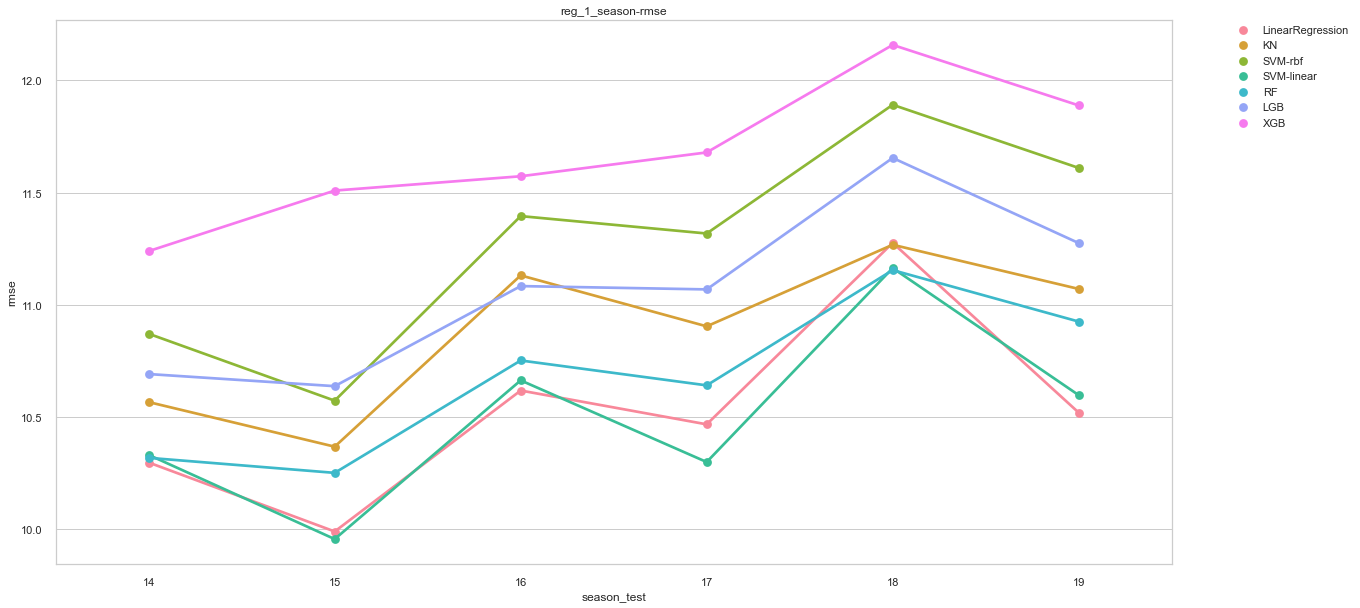

In [23]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

### Experiment using StandardScaler

In [24]:
experiment_name = f"{exp_prefix}scaled_data"

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_scaled_data
Done


,exp_name,model,rmse_mean,rmse_std
7,reg_scaled_data,LinearRegression,10.525680,0.393853
10,reg_scaled_data,SVM-linear,10.594081,0.361405
11,reg_scaled_data,RF,10.673126,0.321704
12,reg_scaled_data,LGB,11.019026,0.382057
9,reg_scaled_data,SVM-rbf,11.046530,0.389984
8,reg_scaled_data,KN,11.214437,0.363486
13,reg_scaled_data,XGB,11.597921,0.319186


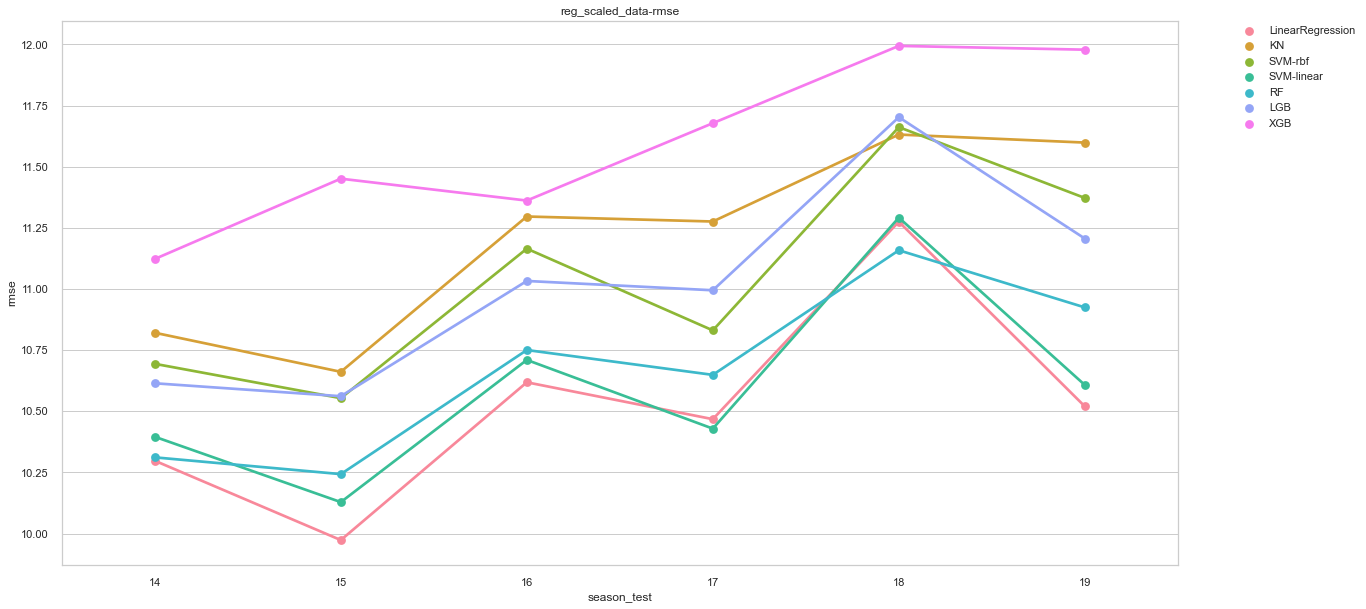

In [25]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment using MinMaxScaler

In [26]:
experiment_name = f"{exp_prefix}minmax_data"

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_minmax_data
Done


,exp_name,model,rmse_mean,rmse_std
17,reg_minmax_data,SVM-linear,10.518627,0.352937
14,reg_minmax_data,LinearRegression,10.529738,0.397308
18,reg_minmax_data,RF,10.672636,0.321963
16,reg_minmax_data,SVM-rbf,10.852241,0.397629
19,reg_minmax_data,LGB,11.026541,0.403355
15,reg_minmax_data,KN,11.129388,0.371591
20,reg_minmax_data,XGB,11.600361,0.317716


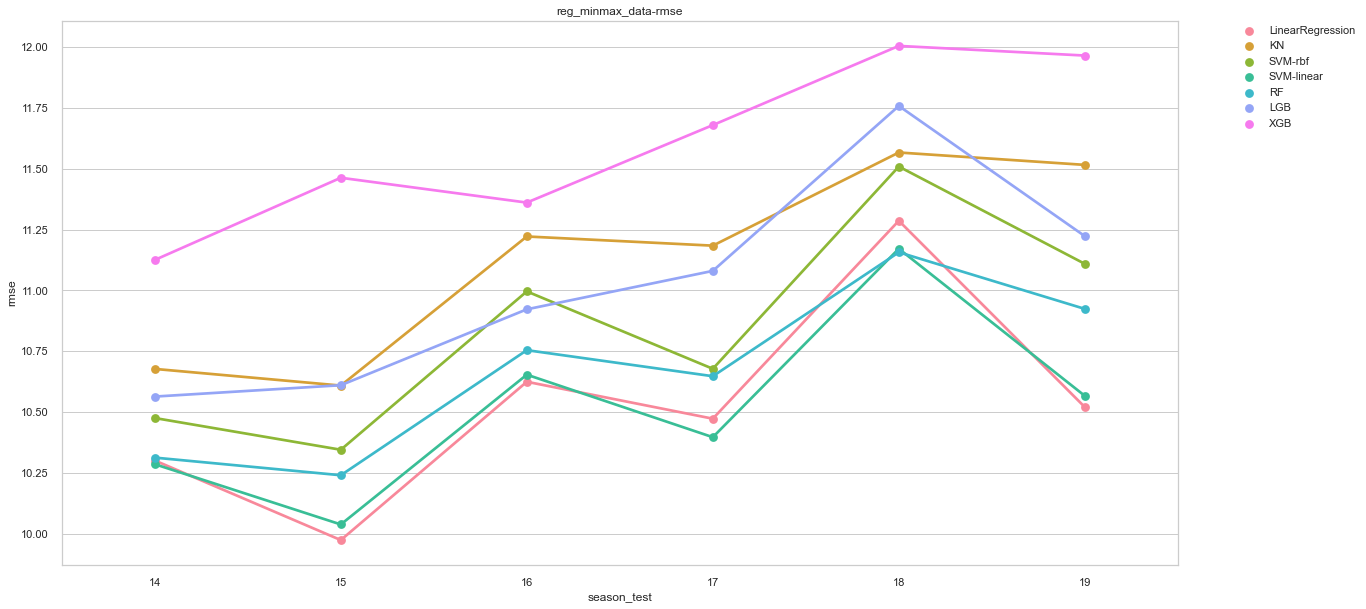

In [27]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment: train: 2s; test: 1s

In [28]:
experiment_name = f"{exp_prefix}2_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2_seasons
Done


,exp_name,model,rmse_mean,rmse_std
21,reg_2_seasons,LinearRegression,10.390301,0.332529
24,reg_2_seasons,SVM-linear,10.454916,0.311276
25,reg_2_seasons,RF,10.557564,0.314073
22,reg_2_seasons,KN,10.827358,0.338473
26,reg_2_seasons,LGB,10.956554,0.343513
23,reg_2_seasons,SVM-rbf,10.983854,0.406163
27,reg_2_seasons,XGB,11.460843,0.295982


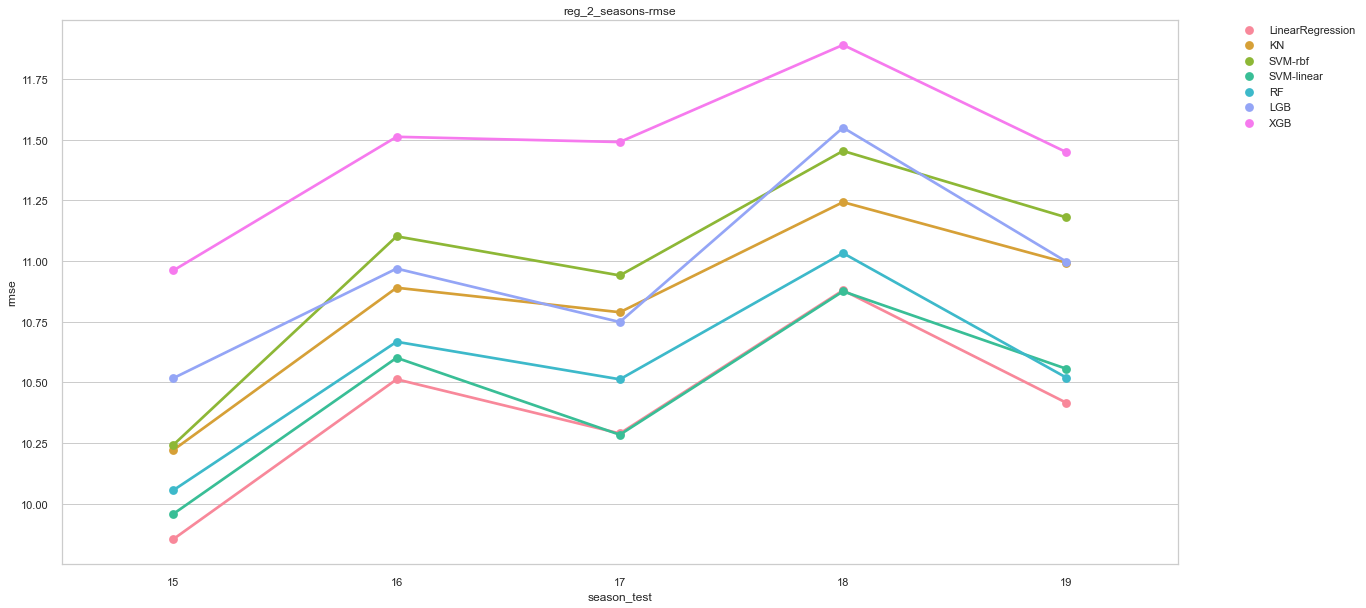

In [29]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment: train: 3s; test: 1s

In [30]:
experiment_name = f"{exp_prefix}3_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3_seasons
Done


,exp_name,model,rmse_mean,rmse_std
28,reg_3_seasons,LinearRegression,10.475449,0.214406
31,reg_3_seasons,SVM-linear,10.550324,0.201820
32,reg_3_seasons,RF,10.615000,0.236618
33,reg_3_seasons,LGB,10.906359,0.260163
29,reg_3_seasons,KN,10.958081,0.150953
30,reg_3_seasons,SVM-rbf,11.014027,0.196912
34,reg_3_seasons,XGB,11.538258,0.240058


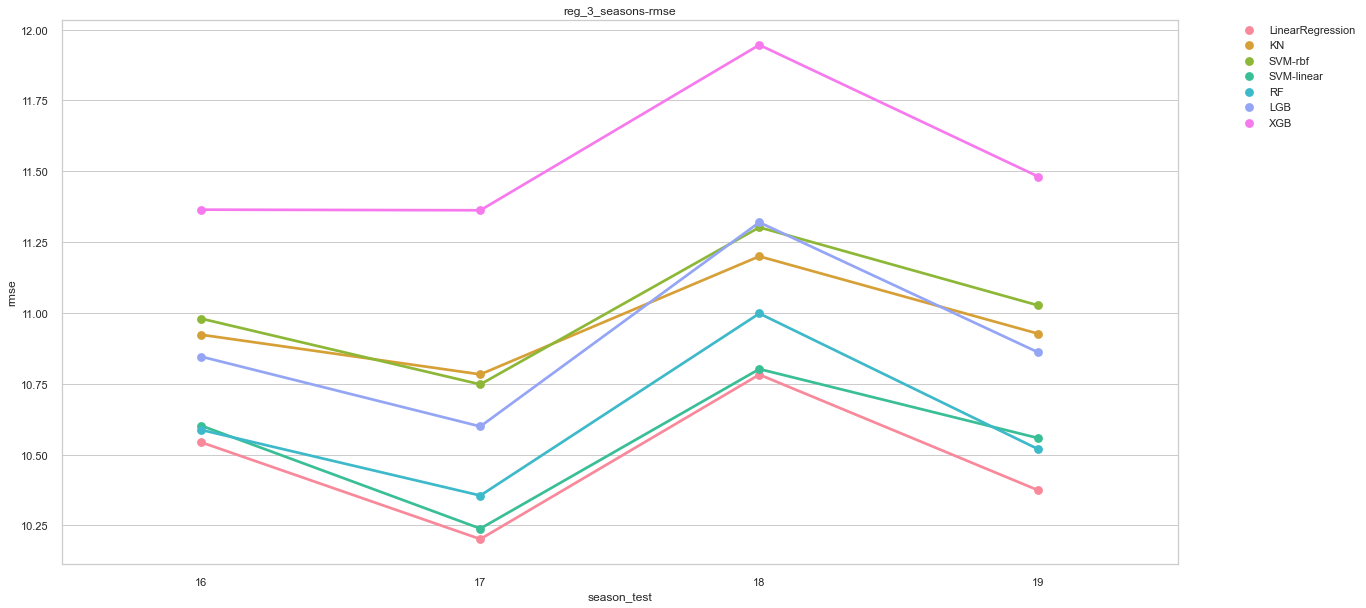

In [31]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment train: 3q ; test: 1q

In [32]:
experiment_name = f"{exp_prefix}3q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q
Done


,exp_name,model,rmse_mean,rmse_std
39,reg_3q_1q,RF,10.708543,0.517968
38,reg_3q_1q,SVM-linear,10.757334,0.606190
35,reg_3q_1q,LinearRegression,10.778857,0.706083
36,reg_3q_1q,KN,11.001713,0.568439
40,reg_3q_1q,LGB,11.122987,0.556829
37,reg_3q_1q,SVM-rbf,11.484501,0.626724
41,reg_3q_1q,XGB,11.792625,0.599363


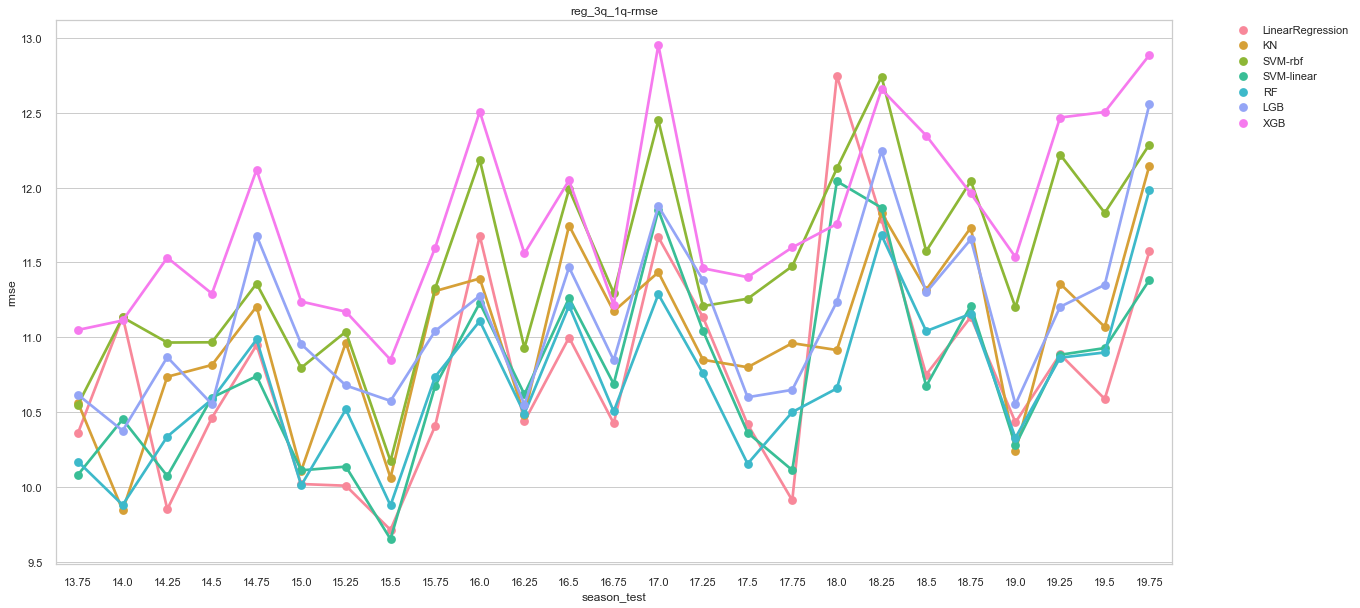

In [33]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment train: 4q ; test: 2q

In [34]:
experiment_name = f"{exp_prefix}4q_2q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_4q_2q
Done


,exp_name,model,rmse_mean,rmse_std
42,reg_4q_2q,LinearRegression,10.457289,0.406950
45,reg_4q_2q,SVM-linear,10.475775,0.432924
46,reg_4q_2q,RF,10.657519,0.393813
43,reg_4q_2q,KN,10.901783,0.384815
47,reg_4q_2q,LGB,11.022619,0.371071
44,reg_4q_2q,SVM-rbf,11.269701,0.466962
48,reg_4q_2q,XGB,11.730726,0.422544


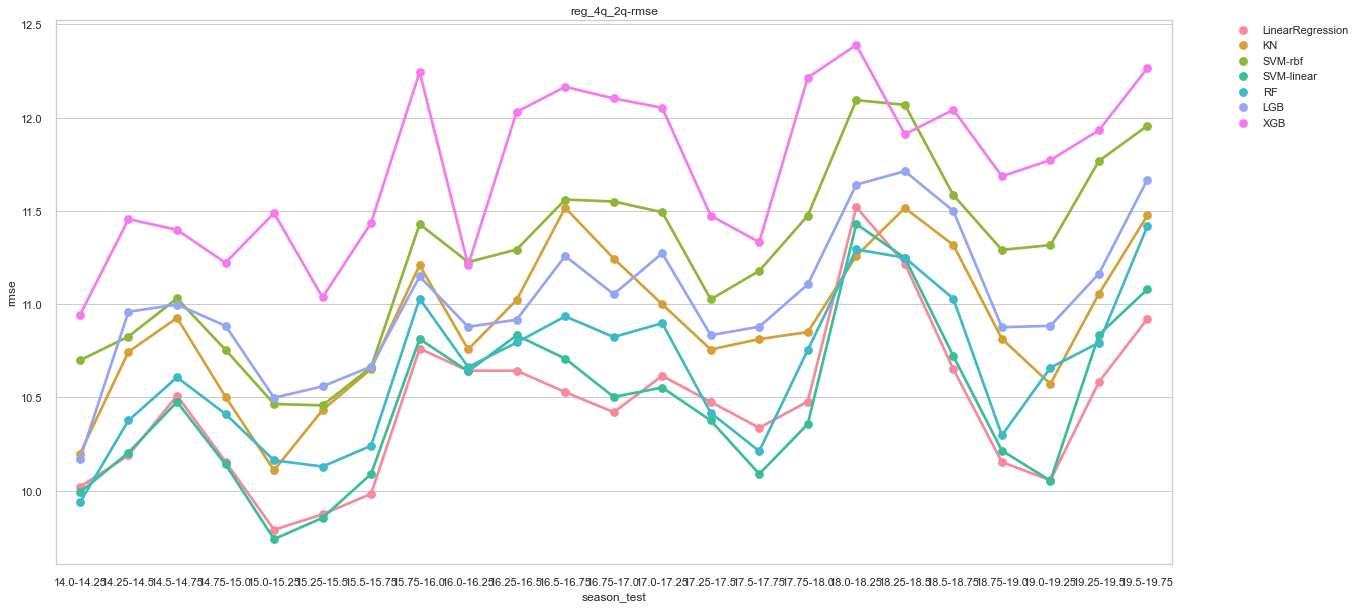

In [35]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [36]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_r1q_2q_1q
Done


,exp_name,model,rmse_mean,rmse_std
53,reg_r1q_2q_1q,RF,10.777613,0.504828
52,reg_r1q_2q_1q,SVM-linear,10.880153,0.638799
49,reg_r1q_2q_1q,LinearRegression,10.920285,0.844481
50,reg_r1q_2q_1q,KN,11.091937,0.484143
54,reg_r1q_2q_1q,LGB,11.162928,0.559733
51,reg_r1q_2q_1q,SVM-rbf,11.591274,0.606340
55,reg_r1q_2q_1q,XGB,11.827286,0.621647


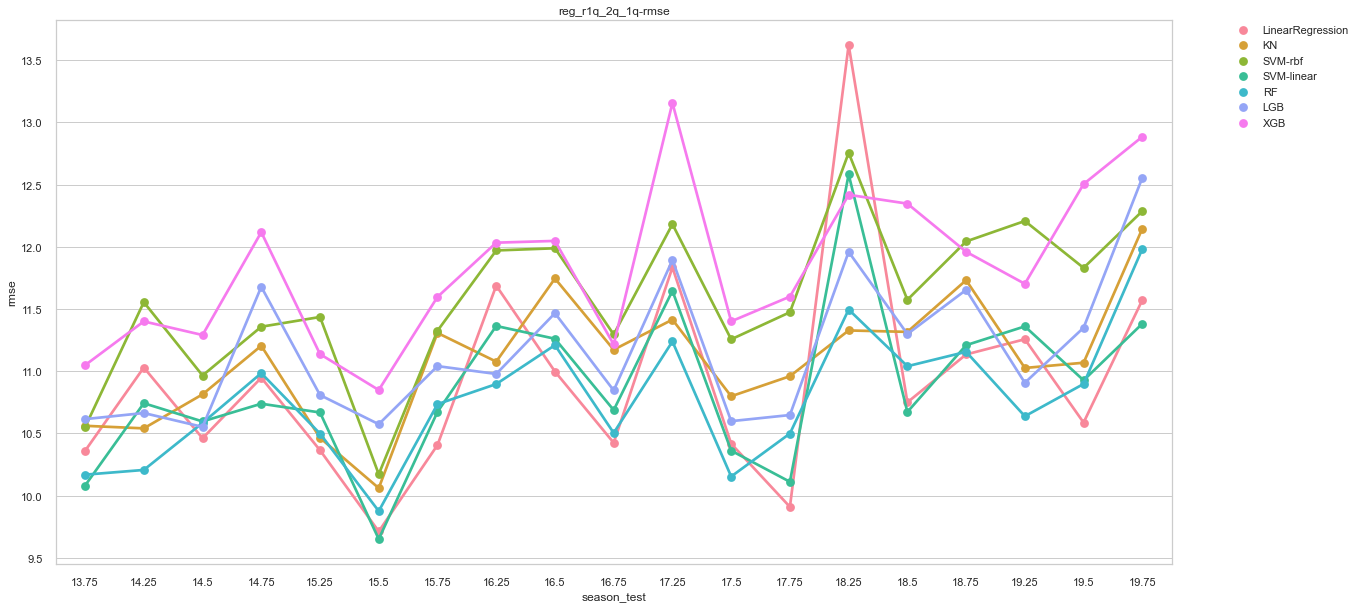

In [37]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

### Experiments comparison

In [38]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [11]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [12]:
ba_df = exp_df[['exp_name', 'model',
       'rmse_mean', 'rmse_std']]

In [14]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [42]:
ba_df.sort_values(
    by=["rmse_mean"]
    , ascending=True)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,rmse_mean,rmse_std
0,reg_2_seasons,LinearRegression,10.390301,0.332529
1,reg_2_seasons,SVM-linear,10.454916,0.311276
2,reg_4q_2q,LinearRegression,10.457289,0.406950
3,reg_3_seasons,LinearRegression,10.475449,0.214406
4,reg_4q_2q,SVM-linear,10.475775,0.432924
5,reg_1_season,SVM-linear,10.502403,0.374099


### Plot experiment results

In [43]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### MAE

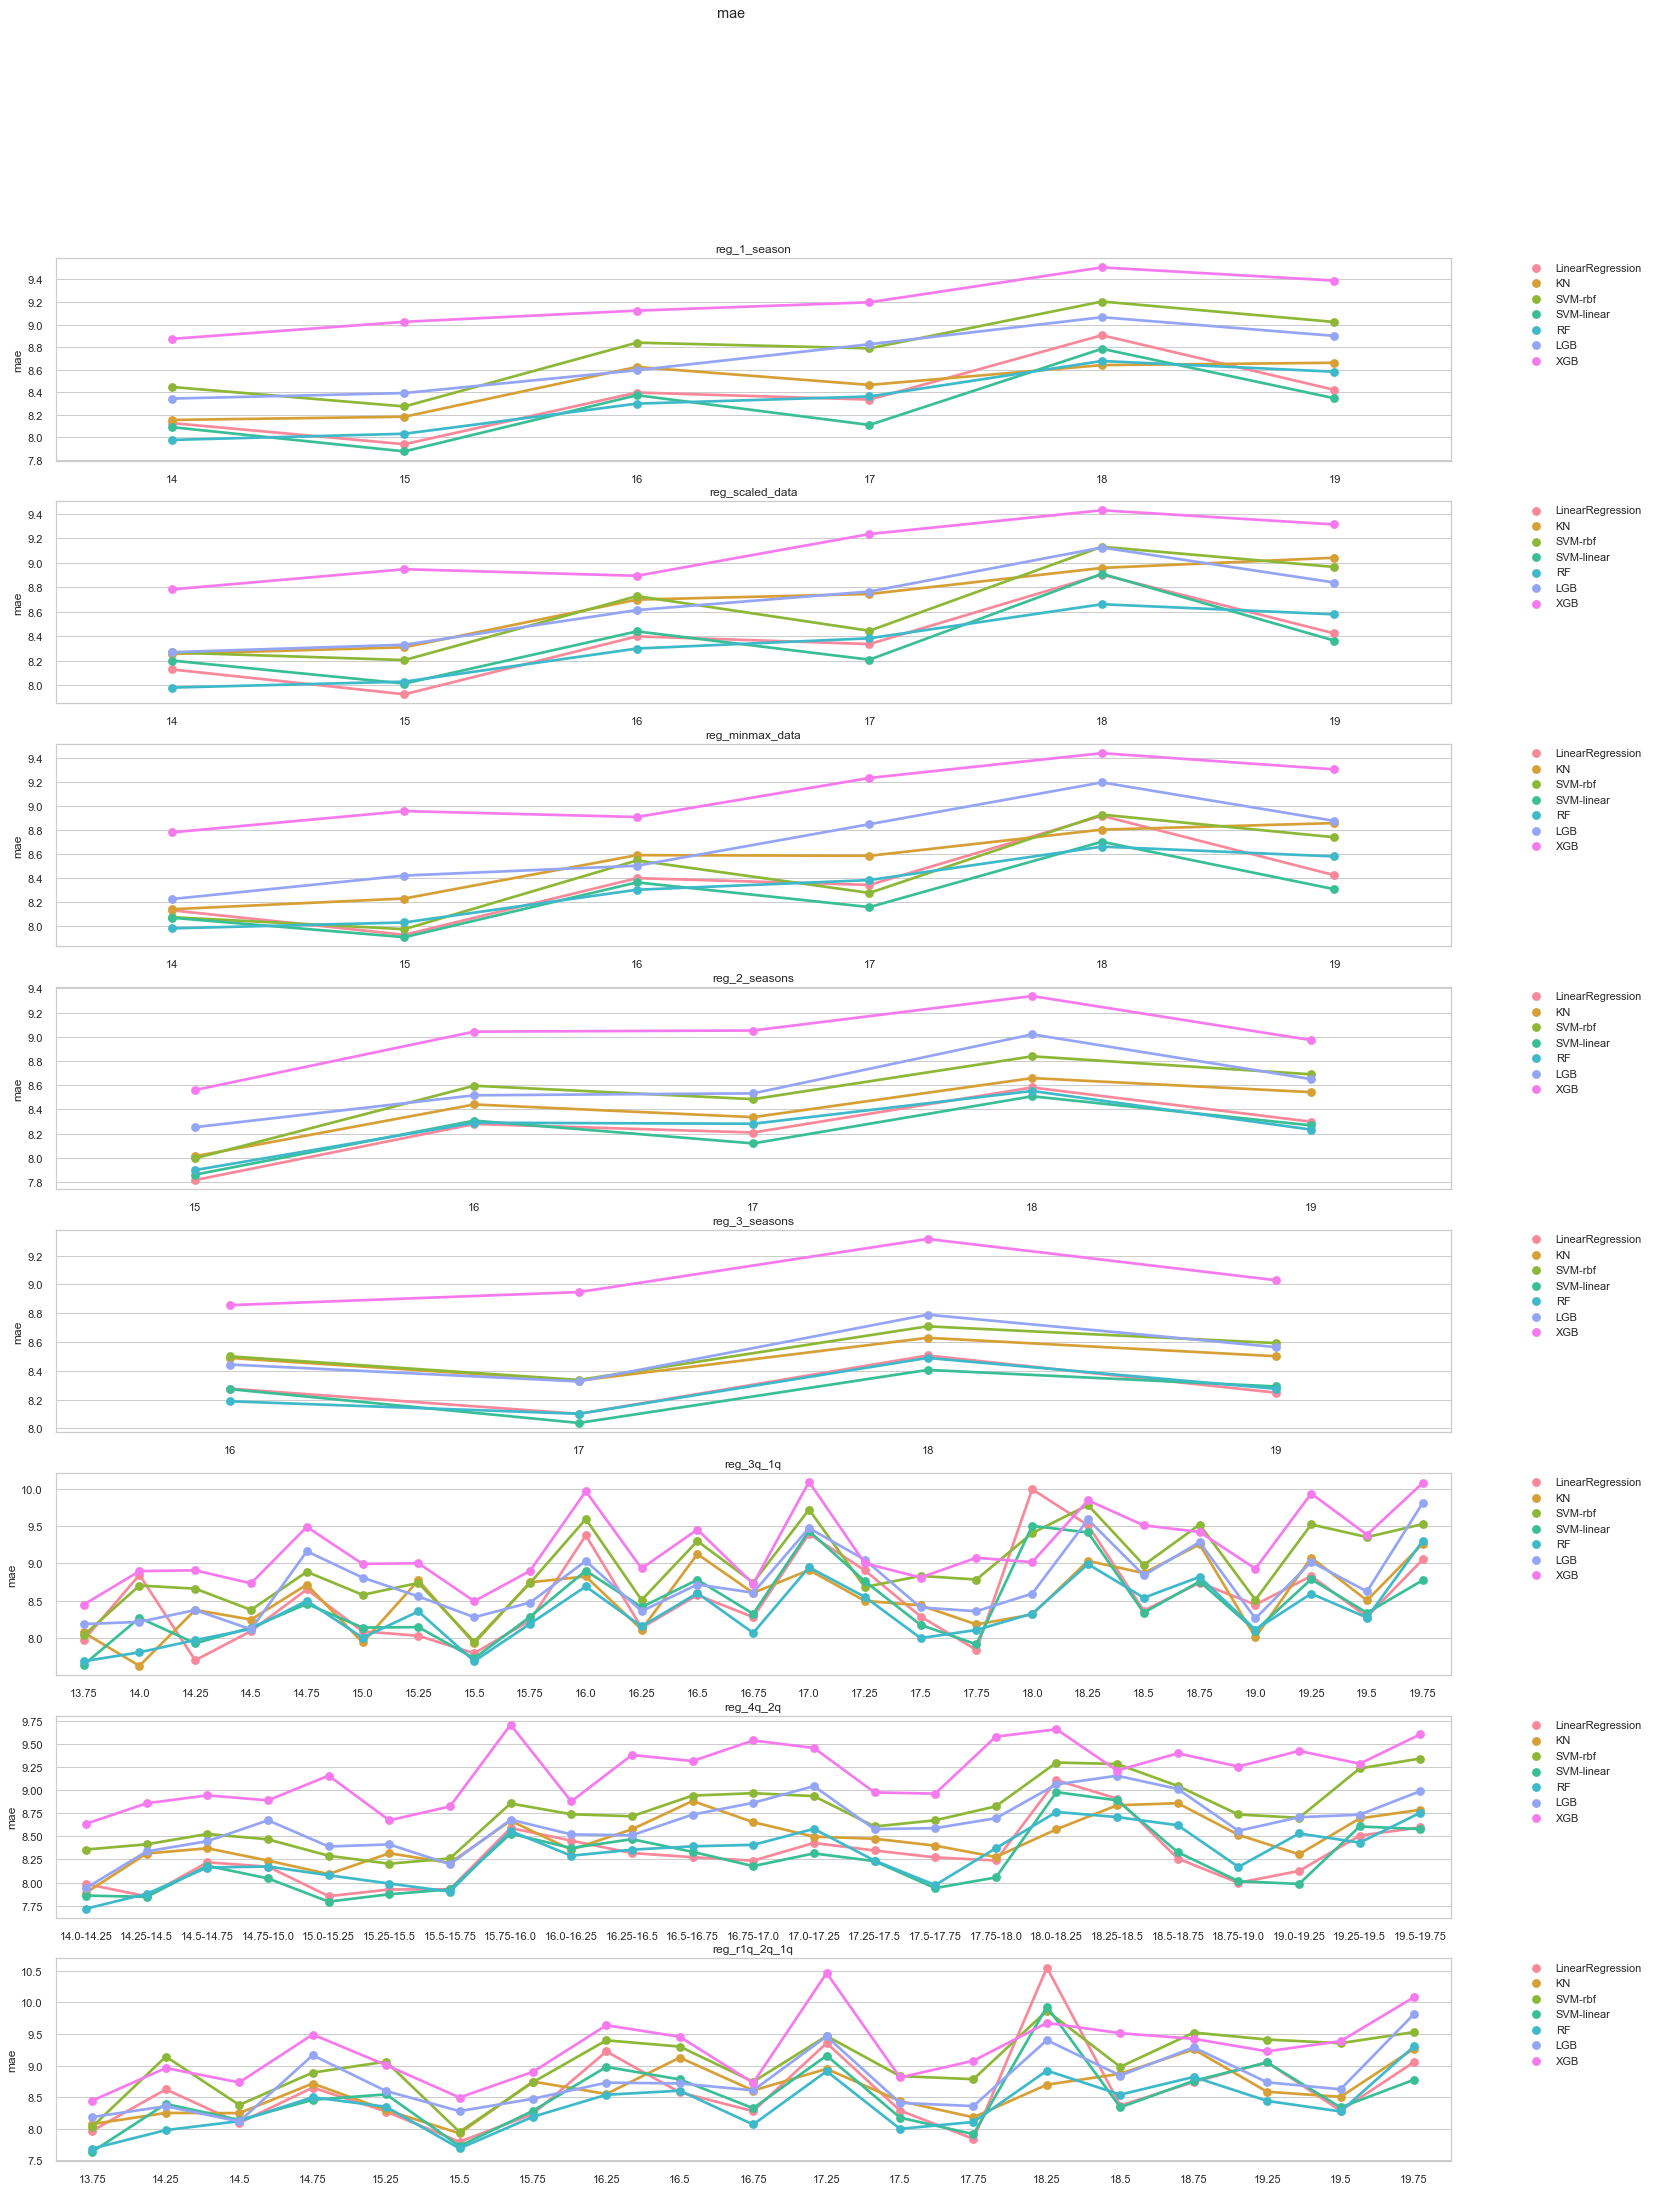

In [44]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mae",
    figsize=(25, 35),
    use_pointplot=True
)

#### MSE

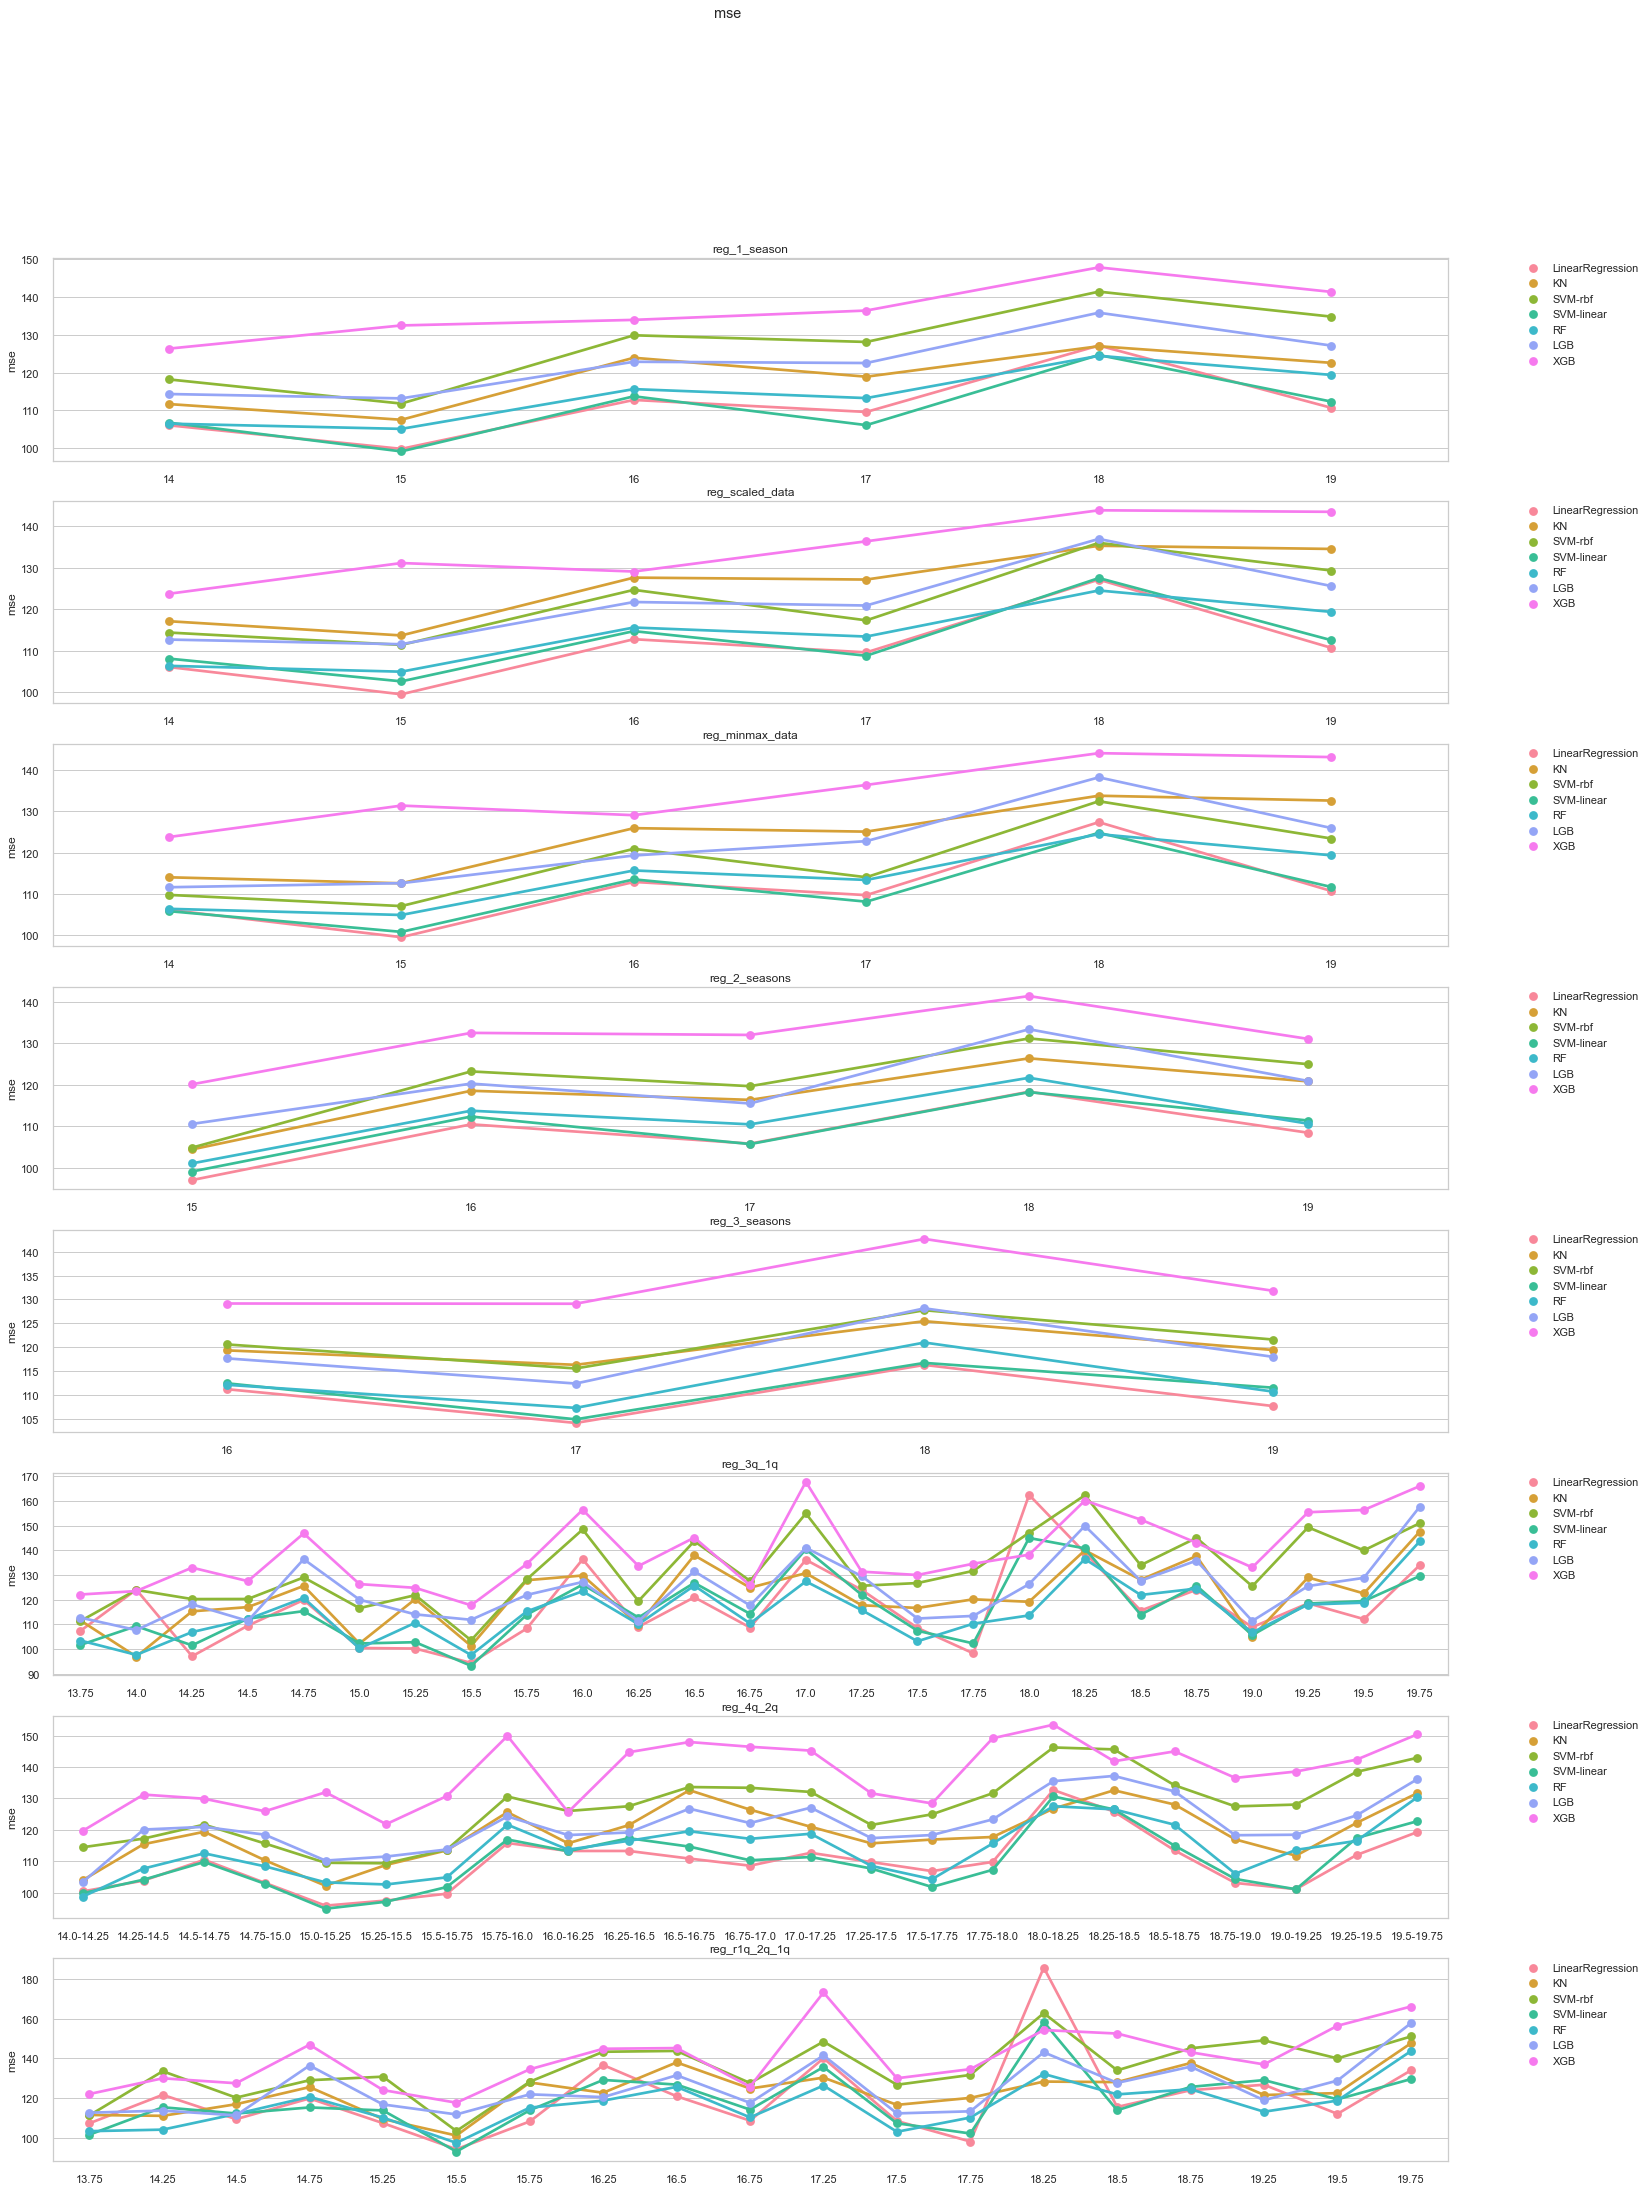

In [45]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mse",
    figsize=(25, 35),
    use_pointplot=True
)

#### RMSE

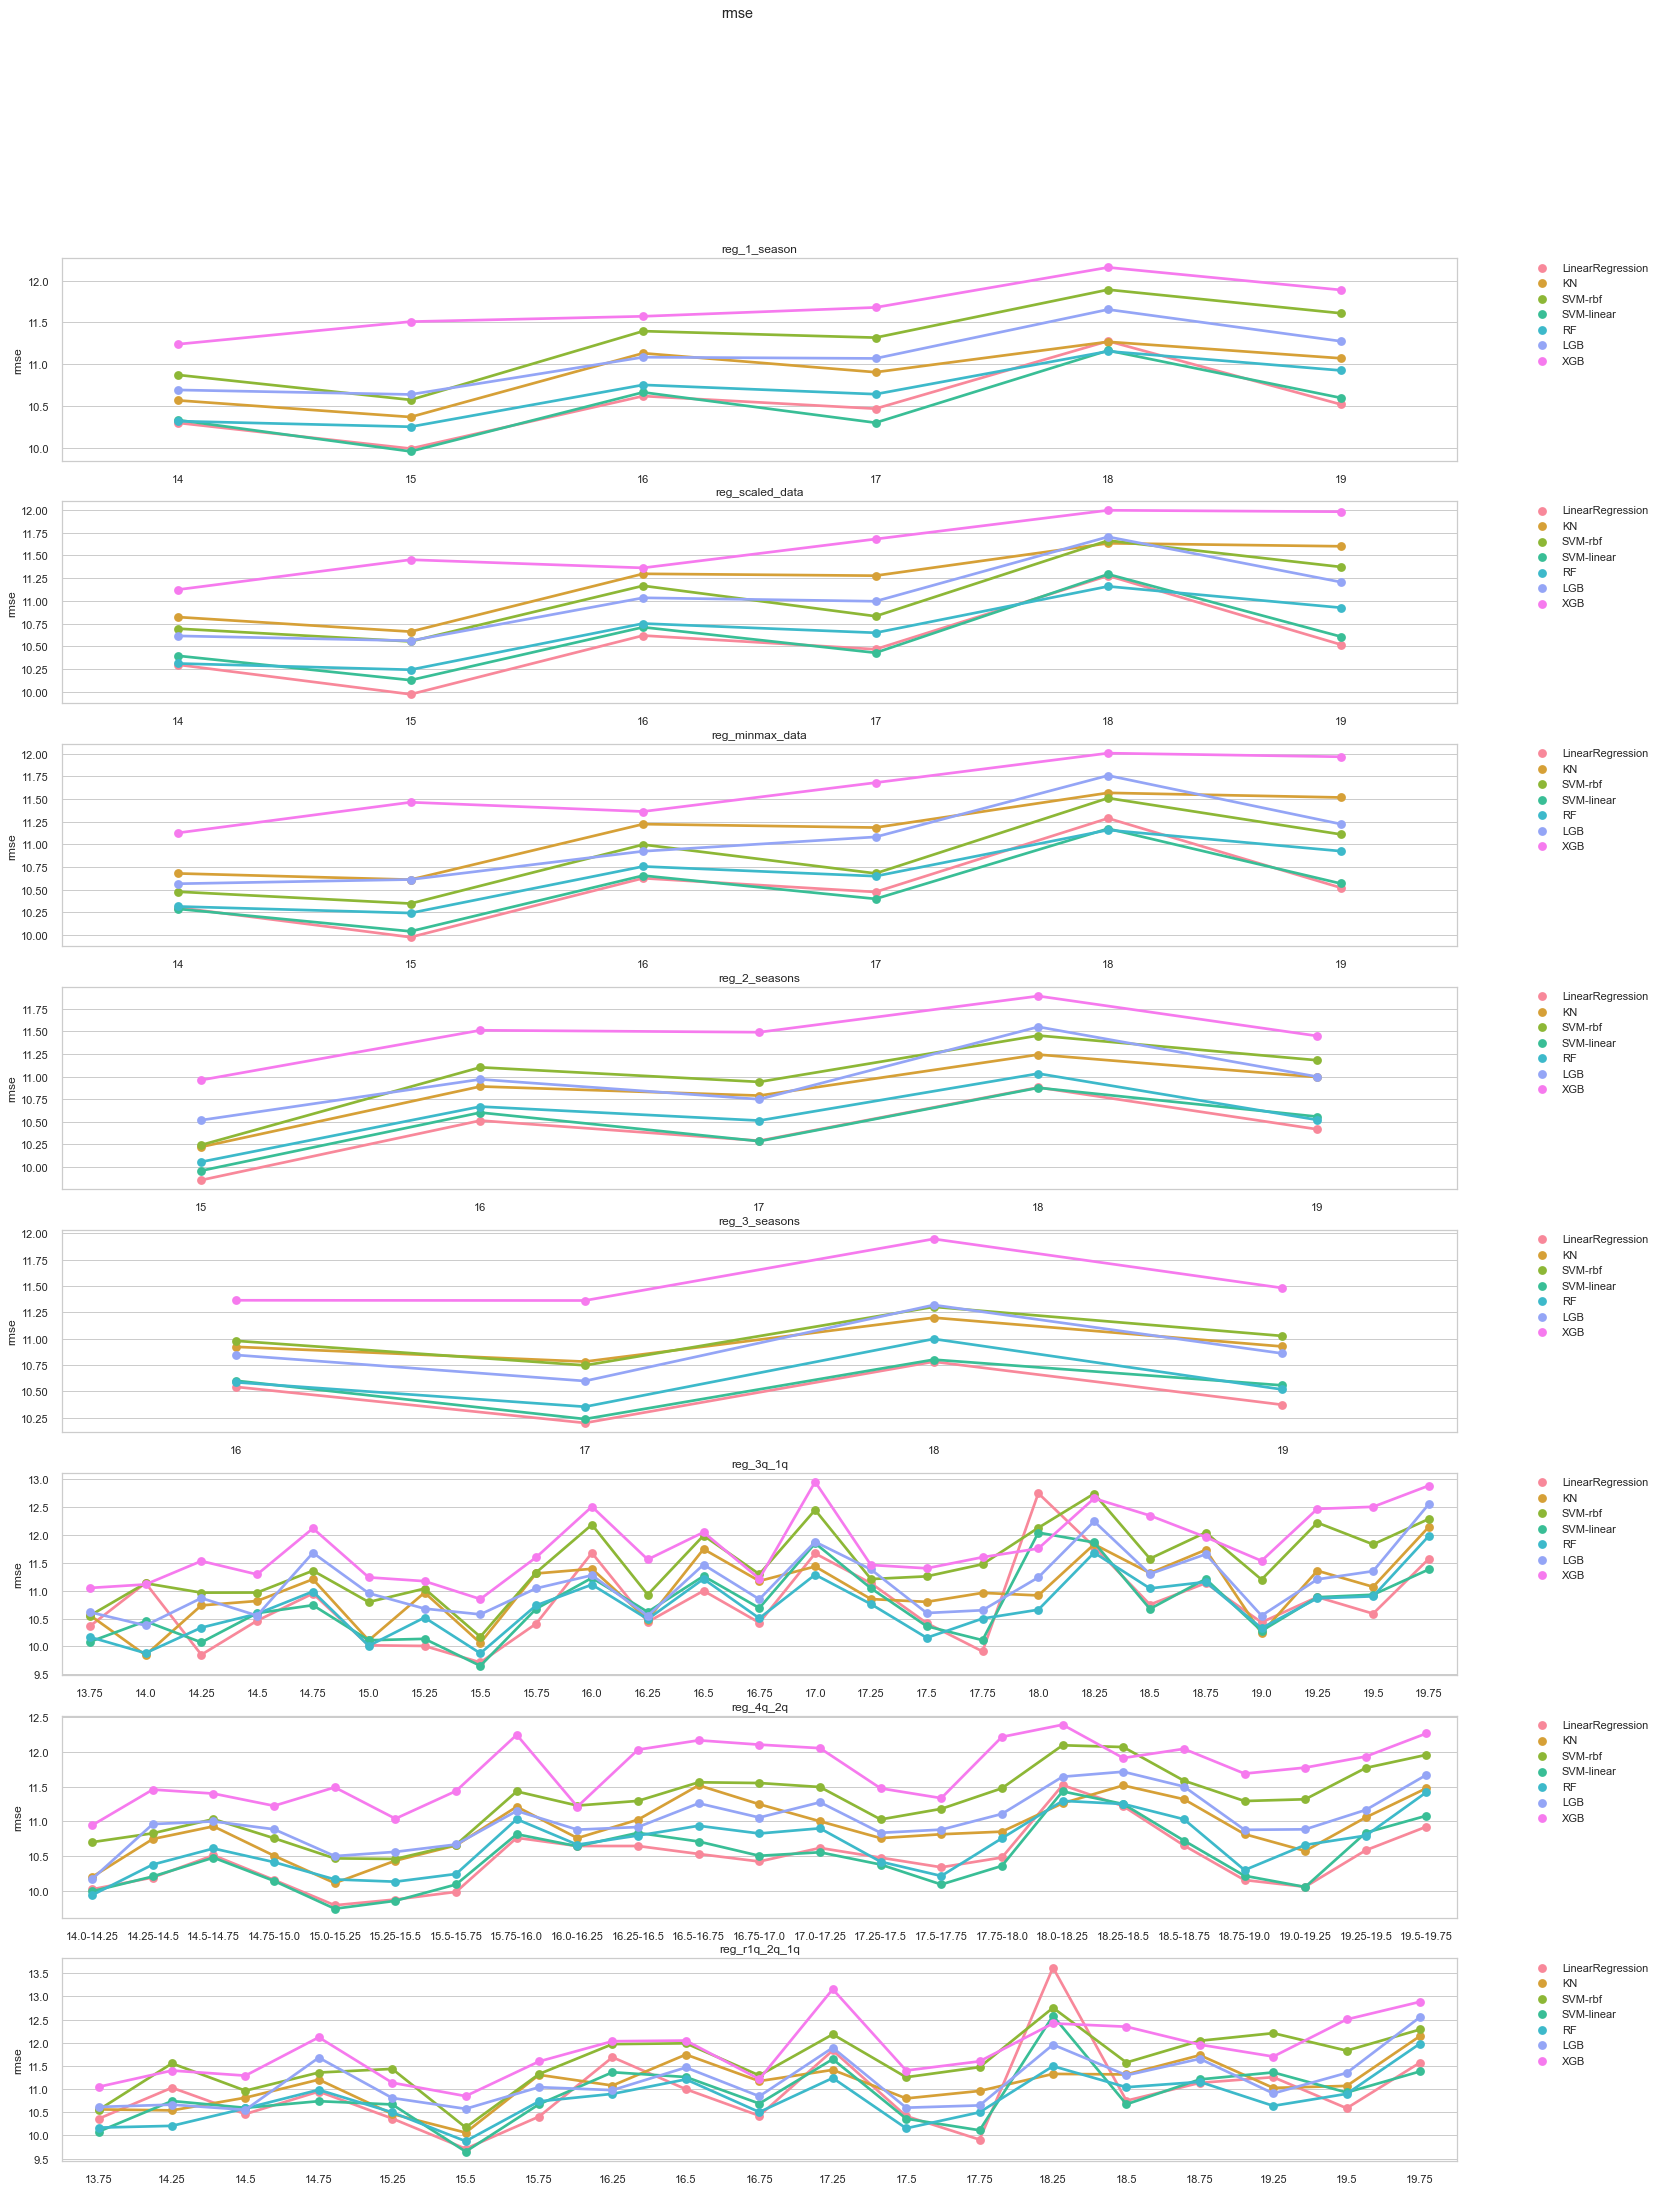

In [46]:
utils.plot_to_compare_experiments(
    results_total,
    metric="rmse",
    figsize=(25, 35),
    use_pointplot=True
)